# Linear Regression for a Non-Linear Features-Target Relationship

In this notebook, we show that even if the parametrization of linear models is not natively adapted to the problem at hand, it is still possible to make linear models more expressive by engineering additional features.

A machine learning pipeline that combines a non-linear feature engineering step followed by a linear regression step can therefore be considered non-linear regression model as a whole.

To illustrate these concepts, we will reuse the same dataset generated in the previous exercise.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
rng = np.random.RandomState(0)
n_sample = 100
data_max, data_min = 1.4, -1.4
len_data = (data_max - data_min)

In [3]:
# sort the data to make plotting easier later
data = np.sort(rng.rand(n_sample)*len_data - len_data / 2)
noise = rng.randn(n_sample) * .3
target = data ** 3 - .5 * data **2 + noise

In [5]:
# data and target as dataframe
full_data = pd.DataFrame({"input_feature": data, "target": target})

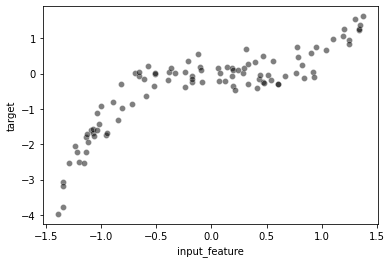

In [6]:
# visualize the data
sns.scatterplot(data=full_data, x="input_feature", y="target",
                    color="black", alpha=0.5);

We will first highlight the limitations of fitting a linear regression model as done in the previous exercise.

In [7]:
# X should be 2D for sklearn: (n_samples, n_features)
data = data.reshape((-1, 1))
data.shape

(100, 1)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [10]:
linear_regression = LinearRegression()
linear_regression.fit(data, target)
target_predicted = linear_regression.predict(data)

In [11]:
mse = mean_squared_error(target, target_predicted)

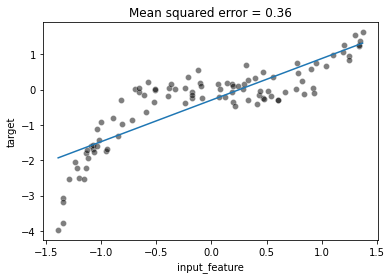

In [12]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
ax.set_title(f"Mean squared error = {mse:.2f}");

Here the coefficient and intercept learnt by `LinearRegression` define the best "straight line" that fits the data. We can inspect the coefficients using the attributes of the learned model as follows:

In [13]:
print(f"weight: {linear_regression.coef_[0]:.2f}, "
      f"intercept: {linear_regression.intercept_:.2f}")

weight: 1.18, intercept: -0.29


It is important to note that the learned model will not be able to handle the non-linear relationship between `data` and `target` since linear models assume the relationship between `data` and `target` to be linear.  

Indeed, there are 3 possibilities to solve this issue:

1. choose a model that can inherently handle with non-linearity,
2. engineer a richer set of features by including expert knowledge which can be directly used by a simple linear model, or
3. use a "kernel" to have a locally-based decision function instead of a global linear decision function.  

Let's illustrate quickly the first point by using a decision tree regressor which can natively handle non-linearity.

In [14]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3).fit(data, target)
target_predicted = tree.predict(data)
mse = mean_squared_error(target, target_predicted)

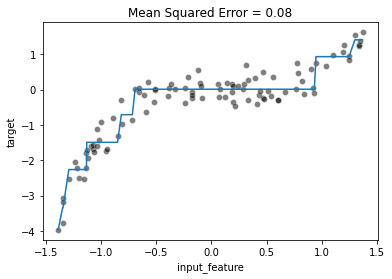

In [16]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                    color='black', alpha=.5)
ax.plot(data, target_predicted)
ax.set_title(f"Mean Squared Error = {mse:.2f}");

Instead of having a model which can deal with non-linearity, we could also modify our data: we could create new features derived from the original features, using some expert knowledge. In this example, we know that we have a cubic and squared relationship between `data` and `target` (because we generated the data). 

Indeed, we could create two new features (`data ** 2` and `data ** 3`) using this information as follows. This kind of transformation is called a <code style="background:yellow;color:black">polynomial feature expansion:</code>

In [17]:
data.shape

(100, 1)

In [18]:
data_expanded = np.concatenate([data, data**2, data**3], axis=1)
data_expanded.shape

(100, 3)

In [19]:
linear_regression.fit(data_expanded, target)
target_predicted = linear_regression.predict(data_expanded)
mse = mean_squared_error(target, target_predicted)

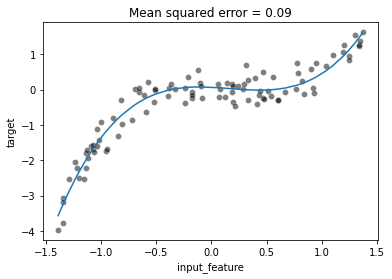

In [21]:
ax = sns.scatterplot(data=full_data, x='input_feature', y='target',
                    color='black', alpha=.5)
ax.plot(data, target_predicted)
ax.set_title(f"Mean squared error = {mse:.2f}");

We can wee that even with a linear model, we can overcome the linearity limitation of the model by adding the non-linear components in the design of additional features. Here, we created new features by knowing the way the target was generated.

Instead of manually creating such polynomial features on could directly use `sklearn.preprocessing.PolynomialFeatures`.

To demonstrate the use of the `PolynomialFeatures` class, we use a scikit-learn pipeline which first transforms the features and then fit the regression model.

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [23]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression(),
)
polynomial_regression.fit(data, target)
target_predicted = polynomial_regression.predict(data)
mse = mean_squared_error(target, target_predicted)

Text(0.5, 1.0, 'Mean squared error = 0.09')

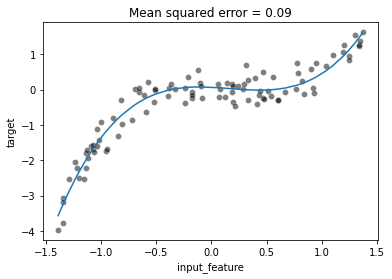

In [24]:
ax = sns.scatterplot(data=full_data, x='input_feature', y='target',
                    color='black', alpha=.5)
ax.plot(data, target_predicted)
ax.set_title(f"Mean squared error = {mse:.2f}");

As expected, we observe that the predictions of the this `PolynomialFeatures` pipeline match the predictions of the linear model fit on manually engineered features.

